In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = 't8btag_minmass'

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False, altfile='t8btag_minmass_{base}') for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False, altfile='t8btag_minmass_{base}') for f in tqdm(module.full_signal_list) ])

bkg = ObjIter([])
# bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile='t8btag_minmass_{base}'), Tree(module.Run2_UL18.TTJets, altfile='t8btag_minmass_{base}')])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile='t8btag_minmass_{base}') ])

100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


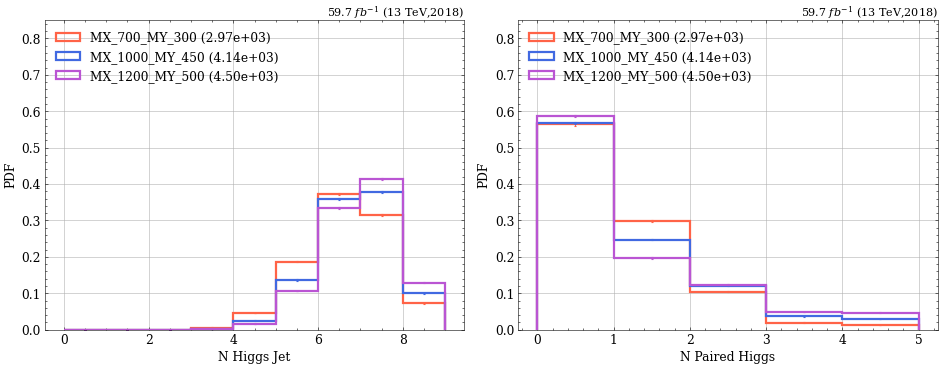

In [6]:
study.quick( 
    signal,
    legend=True,
    varlist=['nfound_select','nfound_paired_h'],
    xlabels=['N Higgs Jet','N Paired Higgs'],
    efficiency=True, ylim=(0,0.85), grid=True,
    saveas=f'{dout}/signal_n_reco'
)

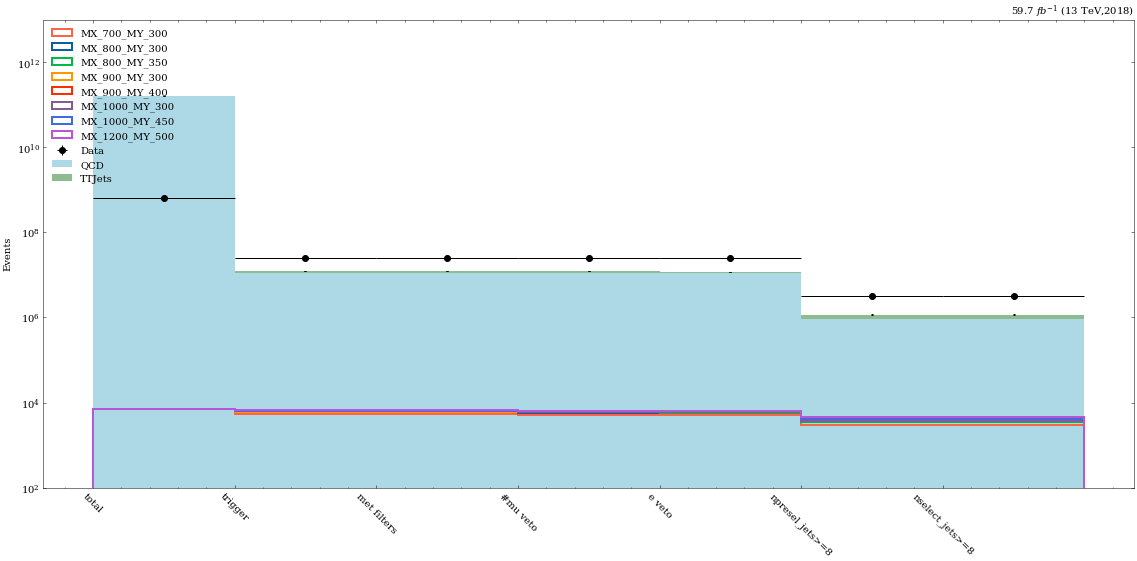

In [6]:
study.cutflow( 
    signal+bkg+data,
    ylim=(1e2, 1e13),
    legend=True
)

In [7]:
def n_presel_jets(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jets)

[None, None, None, None, None, None, None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
(signal+bkg+data).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ordered='pt'))

[None, None, None, None, None, None, None, None, None, None, None]

In [10]:
def higgs_dr(t):
    b1_p4 = build_p4(t, 'higgs_b1')
    b2_p4 = build_p4(t, 'higgs_b2')

    t.extend(higgs_dr = calc_dr_p4(b1_p4, b2_p4))
(signal+bkg+data).apply(higgs_dr)

[None, None, None, None, None, None, None, None, None, None, None]

In [11]:
def build_bdt_features(t):
    jet_ht = ak.sum(t.jet_ptRegressed,axis=-1)

    j1_phi, j2_phi = ak.unzip(ak.combinations(t.jet_phi, n=2, axis=-1))
    jet_dphi = calc_dphi(j1_phi, j2_phi)

    j1_eta, j2_eta = ak.unzip(ak.combinations(t.jet_eta, n=2, axis=-1))
    jet_deta = calc_deta(j1_eta, j2_eta)

    min_jet_deta = ak.min( np.abs(jet_deta), axis=-1)
    max_jet_deta = ak.max( np.abs(jet_deta), axis=-1)

    jet_dr = np.sqrt( jet_deta**2 + jet_dphi**2 )

    min_jet_dr = ak.min(jet_dr, axis=-1)
    max_jet_dr = ak.max(jet_dr, axis=-1)

    h1_phi, h2_phi = ak.unzip(ak.combinations(t.higgs_phi, n=2, axis=-1))
    higgs_dphi = np.abs(calc_dphi(h1_phi, h2_phi))

    h1_eta, h2_eta = ak.unzip(ak.combinations(t.higgs_eta, n=2, axis=-1))
    higgs_deta = np.abs(calc_deta(h1_eta, h2_eta))

    higgs_comb_id = ak.combinations( np.arange(4), n=2, axis=0).tolist()

    t.extend(
        jet_ht=jet_ht,
        min_jet_deta=min_jet_deta,
        max_jet_deta=max_jet_deta,
        min_jet_dr=min_jet_dr,
        max_jet_dr=max_jet_dr,
        **{
            f'h{i+1}{j+1}_dphi':higgs_dphi[:,k]
            for k, (i,j) in enumerate(higgs_comb_id)
        },
        **{
            f'h{i+1}{j+1}_deta':higgs_deta[:,k]
            for k, (i,j) in enumerate(higgs_comb_id)
        },
        **{
            f'h{i+1}_{var}':t[f'higgs_{var}'][:,i]
            for i in range(4)
            for var in ('pt','dr')
        },
    )
(signal+bkg+data).apply(build_bdt_features, report=True)

100%|██████████| 11/11 [00:26<00:00,  2.42s/it]


[None, None, None, None, None, None, None, None, None, None, None]

In [12]:
(signal+bkg+data).write(
    f"{dout}_{{base}}"
)

Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_700_MY_300/t8btag_minmass_ntuple.root


[71.02MB/71.02MB][100%][==================================================][71.02MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_800_MY_300/t8btag_minmass_ntuple.root


[82.75MB/82.75MB][100%][==================================================][82.75MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_800_MY_350/t8btag_minmass_ntuple.root


[84.68MB/84.68MB][100%][==================================================][84.68MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_900_MY_300/t8btag_minmass_ntuple.root


[86.81MB/86.81MB][100%][==================================================][86.81MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_900_MY_400/t8btag_minmass_ntuple.root


[93.48MB/93.48MB][100%][==================================================][93.48MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1000_MY_300/t8btag_minmass_ntuple.root


[88.83MB/88.83MB][100%][==================================================][44.41MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1000_MY_450/t8btag_minmass_ntuple.root


[99.9MB/99.9MB][100%][==================================================][99.9MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/NMSSM_XYY_YToHH_8b/NMSSM_XYY_YToHH_8b_MX_1200_MY_500/t8btag_minmass_ntuple.root


[108.4MB/108.4MB][100%][==================================================][54.18MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[280.3kB/280.3kB][100%][==================================================][280.3kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[330.3kB/330.3kB][100%][==================================================][330.3kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[1.935MB/1.935MB][100%][==================================================][1.935MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[13.5MB/13.5MB][100%][==================================================][13.5MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[7.486MB/7.486MB][100%][==================================================][7.486MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[11.25MB/11.25MB][100%][==================================================][11.25MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[19.25MB/19.25MB][100%][==================================================][19.25MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_bEnriched_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[20.75MB/20.75MB][100%][==================================================][20.75MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT100to200_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[282.5kB/282.5kB][100%][==================================================][282.5kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT200to300_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[298.7kB/298.7kB][100%][==================================================][298.7kB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT300to500_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[1.399MB/1.399MB][100%][==================================================][1.399MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT500to700_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[7.288MB/7.288MB][100%][==================================================][7.288MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT700to1000_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[12.44MB/12.44MB][100%][==================================================][12.44MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT1000to1500_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[9.458MB/9.458MB][100%][==================================================][9.458MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT1500to2000_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[12.83MB/12.83MB][100%][==================================================][12.83MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/QCD/QCD_HT2000toInf_BGenFilter_TuneCP5_13TeV-madgraph-pythia8/t8btag_minmass_ntuple.root


[15.38MB/15.38MB][100%][==================================================][15.38MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/TTJets/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/t8btag_minmass_ntuple_0.root


[364.8MB/364.8MB][100%][==================================================][91.21MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018A/t8btag_minmass_ntuple.root


[790.9MB/790.9MB][100%][==================================================][113MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018B/t8btag_minmass_ntuple.root


[356MB/356MB][100%][==================================================][71.2MB/s]   


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018C/t8btag_minmass_ntuple.root


[311.2MB/311.2MB][100%][==================================================][103.7MB/s]  


Writing //store/user/ekoenig/8BAnalysis/NTuples/2018/preselection/t8btag_minmass/Run2_UL/RunIISummer20UL18NanoAODv9/JetHT_Data/JetHT_Run2018D/t8btag_minmass_ntuple.root


[1.279GB/1.279GB][100%][==================================================][87.3MB/s]   


[None, None, None, None, None, None, None, None, None, None, None]